In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.patches as mpatches
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import Ridge
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
import lightgbm as lgb
from datetime import datetime
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder, StandardScaler

%matplotlib inline 
import warnings                   # To ignore the warnings
warnings.filterwarnings("ignore")

In [50]:
cassava_data = pd.read_csv("cassava_dataset.csv")
weather_data = pd.read_csv("weather data.csv")
cassava_data.describe().T

,count,mean,std,min,25%,50%,75%,max
year,24637.0,2015.156310,2.304484,1996.0,2013.0000,2015.000,2017.00000,2022.0
plotWidth,21955.0,2.383739,1.696465,1.0,1.0000,1.000,4.00000,16.0
plotLength,21955.0,4.909387,1.727796,2.5,3.5000,5.500,5.50000,20.0
fieldSize,15988.0,0.328239,0.320640,0.0,0.1024,0.215,0.58975,7.2
rep,24637.0,1.989853,6.093928,1.0,1.0000,1.000,2.00000,146.0
...,...,...,...,...,...,...,...,...
stemwt,4.0,6.425000,4.350000,0.8,4.4000,6.950,8.97500,11.0
storgshp,19909.0,2.140841,0.497991,1.0,2.0000,2.000,2.00000,7.0
rtsz,19555.0,4.330095,1.318708,2.0,3.0000,5.000,5.00000,7.0
tyld,15015.0,25.239272,20.601212,0.0,13.8000,22.500,32.60000,1512.5


In [51]:
cassava_data.columns

Index(['year', 'programName', 'trial', 'studyDesign', 'plotWidth',
       'plotLength', 'fieldSize', 'plantingDate', 'harvestDate', 'location',
       'accession', 'plotname', 'rep', 'block_num', 'plot_num', 'row_num',
       'col_num', 'entryType', 'brnhbt', 'brnhlv', 'cad3i', 'cad6i', 'cad9i',
       'cad3s', 'cad6s', 'cad9s', 'cbb3i', 'cbb6i', 'cbb9i', 'cbb3s', 'cbb6s',
       'cbb9s', 'cbsd12i', 'cbsdr12s', 'cgm1', 'cgm2', 'cmbs', 'cmd1i',
       'cmd12i', 'cmd3i', 'cmd6i', 'cmd9i', 'cmd1s', 'cmd12s', 'cmd3s',
       'cmd6s', 'cmd9s', 'dmspg', 'dm', 'dmQ', 'dyld', 'fibre', 'brnht',
       'fyld', 'fshtwt', 'fstortwt', 'hi', 'vigor', 'mkrtwt', 'nmrtwt',
       'pltsk', 'petcol', 'pltarc', 'pltht', 'nohav', 'lodplt', 'rtvr',
       'nklgt', 'rtno', 'rwtair', 'rwtwat', 'rtrot', 'spgrv', 'sprtct9',
       'sprtct1', 'sprtct6', 'sprtct3', 'sprout', 'Starch', 'sg', 'stmcol',
       'stemwt', 'storgshp', 'rtsz', 'tyld', 'yldQ'],
      dtype='object')

In [52]:
## Wrangle weather data

w_df = weather_data.copy()
w_df.columns = [cols.lower() for cols in w_df.columns]
w_df = w_df.drop(columns=["allsky_sfc_sw_dwn","clrsky_sfc_sw_dwn"]).replace(-999.0, np.nan).dropna()

w_df['date'] = w_df[['year', 'mo', 'dy']].astype('str').agg('/'.join, axis=1)
weather_data_ibadan = w_df.drop(columns = ['year','mo','dy'])

In [53]:
## Filter out all the cassava data from Ibadan

cassava_data_ibadan = cassava_data[cassava_data['location'] == "Ibadan"]
cassava_data_ibadan.columns = [cols.lower() for cols in cassava_data_ibadan.columns]
cassava_data_ibadan = cassava_data_ibadan.drop(columns=['plotlength', 'plotwidth', 'dyld','tyld', 'dmspg', 'hi', 'studydesign', 'trial', 'plot_num', 'plotname','block_num','rep','fieldsize', 'programname','col_num','row_num'])
cassava_data_ibadan = cassava_data_ibadan.dropna(subset=["dm","fyld","spgrv","plantingdate","harvestdate"])

cassava_data_ibadan['planting_month'] = pd.to_datetime(cassava_data_ibadan['plantingdate'])
cassava_data_ibadan["planting_date"] = [full_date.strftime('%Y-%m-%d') for full_date in cassava_data_ibadan['planting_month']]

cassava_data_ibadan['harvest_month'] = pd.to_datetime(cassava_data_ibadan['harvestdate'])
cassava_data_ibadan["harvest_date"] = [full_date.strftime('%Y-%m-%d') for full_date in cassava_data_ibadan['harvest_month']]
cassava_data_ibadan = cassava_data_ibadan.drop(columns = ["year","harvest_month",'harvestdate',"planting_month",'plantingdate'])

cassava_data_ibadan = cassava_data_ibadan.reset_index().drop(columns="index")

In [54]:
weather_data_ibadan['date'] = pd.to_datetime(weather_data_ibadan['date'])

planting_dates = list(cassava_data_ibadan["planting_date"])
harvest_dates = list(cassava_data_ibadan["harvest_date"])

agg_data_array = []
days = []

for i in range(0, len(planting_dates)):
    filtered_data = weather_data_ibadan[(weather_data_ibadan["date"] >= planting_dates[i]) & (weather_data_ibadan['date'] <= harvest_dates[i])]
    aggregated_data = filtered_data.mean()
    agg_data_array.append(aggregated_data)
    
    start_date = datetime.strptime(planting_dates[i], '%Y-%m-%d')
    end_date = datetime.strptime(harvest_dates[i], '%Y-%m-%d')
    difference =  end_date - start_date
    number_of_days = difference.days
    days.append(number_of_days)    

cassava_data_ibadan["number_of_days"] = days
agg_weather_data = pd.DataFrame(agg_data_array).drop(columns = "date")

In [55]:
cass_weather_data = pd.concat([cassava_data_ibadan, agg_weather_data], axis=1)
cass_weather_data.head(3)
cass_weather_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4218 entries, 0 to 4217
Data columns (total 75 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   location          4218 non-null   object 
 1   accession         4218 non-null   object 
 2   entrytype         4218 non-null   object 
 3   brnhbt            0 non-null      float64
 4   brnhlv            100 non-null    float64
 5   cad3i             1 non-null      float64
 6   cad6i             3811 non-null   float64
 7   cad9i             2988 non-null   float64
 8   cad3s             0 non-null      float64
 9   cad6s             3918 non-null   float64
 10  cad9s             3083 non-null   float64
 11  cbb3i             4166 non-null   object 
 12  cbb6i             4054 non-null   float64
 13  cbb9i             4 non-null      float64
 14  cbb3s             4167 non-null   object 
 15  cbb6s             4056 non-null   float64
 16  cbb9s             4 non-null      float64


In [56]:
# time_series.set_index("harvest_date", inplace=True)

In [71]:
time_series = cass_weather_data[["harvest_date", "fyld", "dm","number_of_days"]]
time_series['harvest_date'] = pd.to_datetime(time_series.harvest_date,format='%Y-%m-%d') 
time_series["year"] = time_series.harvest_date.dt.year
time_series["month"] = time_series.harvest_date.dt.month

time_series = time_series.groupby("number_of_days").mean().sort_values(by = "number_of_days")

print(time_series)


                                harvest_date       fyld         dm  \
number_of_days                                                       
162            2013-02-09 00:00:00.000000000  21.166667  32.088333   
222            2018-06-11 00:00:00.000000000  32.790488  36.000000   
274            2017-09-10 00:00:00.000000000  23.971892  38.356757   
285            2018-07-11 00:00:00.000000000  22.909636  37.545455   
311            2023-06-13 00:00:00.000000000  23.850000  17.750000   
314            2018-09-11 00:00:00.000000000  25.127660  36.472766   
319            2014-09-16 00:00:00.000000000  17.012500  36.458333   
320            2014-09-15 00:00:00.000000000  17.773134  36.023881   
325            2017-09-15 00:00:00.000000000  25.158750  37.968750   
326            2017-07-10 00:00:00.000000000  25.946429  25.514286   
327            2017-07-11 00:00:00.000000000  20.211667  30.183333   
330            2015-04-08 00:00:00.000000000  14.680597  21.582090   
333            2014-

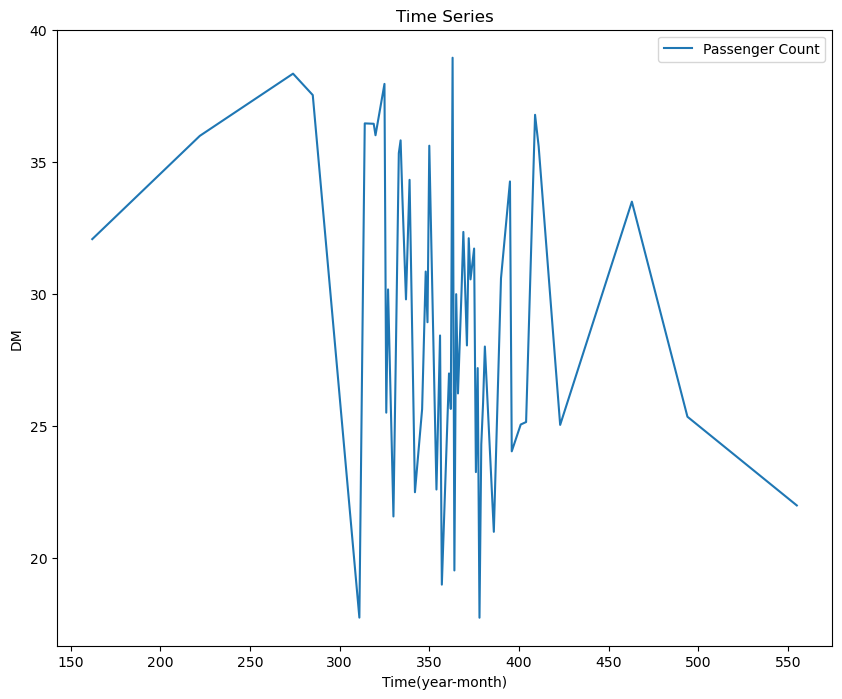

In [73]:
# time_series.index = time_series['harvest_date'] 
ts = time_series['dm'] 
plt.figure(figsize=(10,8)) 
plt.plot(ts, label='Passenger Count') 
plt.title('Time Series') 
plt.xlabel("Time(year-month)") 
plt.ylabel("DM") 
plt.legend(loc='best')

In [61]:
time_series = cass_weather_data[["harvest_date", "dm"]]
time_series.set_index("harvest_date", inplace=True)
print(time_series)

                dm
harvest_date      
2012-05-31    32.5
2012-05-31    39.4
2012-05-31    36.4
2012-05-31    38.4
2012-05-31    33.8
...            ...
2023-05-31    19.3
2023-05-22    25.0
2023-05-22    25.1
2023-06-13    18.5
2023-06-13    17.0

[4218 rows x 1 columns]


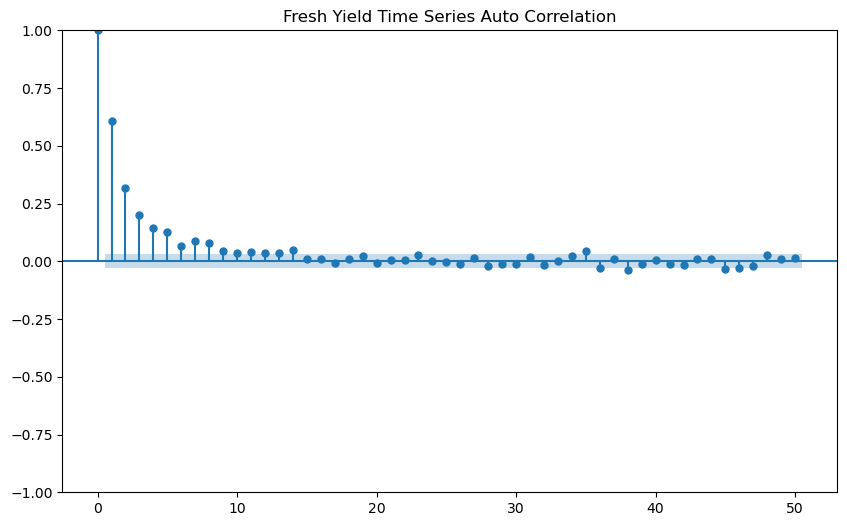

In [64]:
plt.rc("figure", figsize=(10,6))
plot_pacf(time_series, lags=50, title="Fresh Yield Time Series Auto Correlation")
plt.show()


                dm
harvest_date      
2012-05-31    32.5
2012-05-31    39.4
2012-05-31    36.4
2012-05-31    38.4
2012-05-31    33.8
...            ...
2023-05-31    19.3
2023-05-22    25.0
2023-05-22    25.1
2023-06-13    18.5
2023-06-13    17.0

[4218 rows x 1 columns]


<Figure size 1000x600 with 0 Axes>

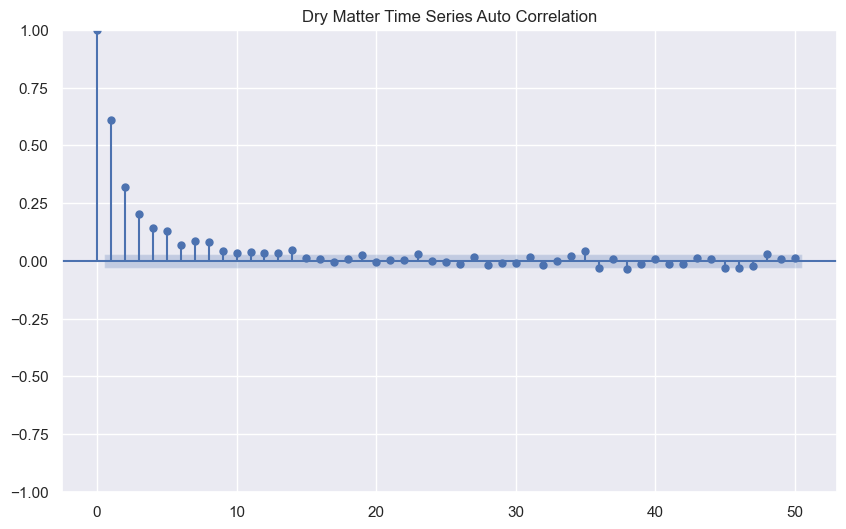

In [ ]:
time_series = cass_weather_data[["harvest_date", "dm"]]
time_series.set_index("harvest_date", inplace=True)
print(time_series)

plt.figure(figsize=(10, 6))
plot_pacf(time_series, lags=50,title="Dry Matter Time Series Auto Correlation")
plt.show()
